#S1. Import and Initalize DataFrame

In [ ]:
#link to dataset: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?resource=download&select=Fake.csv

import numpy as np
import seaborn as sns
import pandas as pd

#i will import keras and skl later as needed to see where the parts fit in

from google.colab import drive
drive.mount('/content/drive')

true_path = "/content/drive/My Drive/True.csv"
fake_path = "/content/drive/My Drive/fake.csv"

fake = pd.read_csv(fake_path)
true = pd.read_csv(true_path)

#make labels so when combining no data is lost
true['label'] = 1
fake['label'] = 0

#combine them into one but keep target variable labeled so as not to mix up data
#ignore index bc if not, every index would be double labeled

df = pd.concat([true, fake], ignore_index=True)

#keep full data in here in case i want to go back for some rsn
full_data = df

#just discern if fake or not based on the title, to see if clickbait
df = df[['title', 'label']]


Mounted at /content/drive


#S2. Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split

#.values as it vectorizes these, turning a pd series into a np array, which is what keras expects
x = df['title'].values
y = df['label'].values

#tts from skl only for tts() method, .20 indicating 80% is for training
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

#tokenizer only keeps the 10k most common words for pattern recognition, limits the noise

#oov = out of vocabulary ... any word in test not seen in train gets replaced as it doesnt recognize it
#that prevents the unseen words from interfering with the model

#fit_on_texts looks at all the words in train and keeps count of the 10k most common, forming patterns
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)



##Understanding the Tokenizer, Most Common Words

In [ ]:
# get dictionary of most common words
most_common = tokenizer.word_index

# split into two aligned lists
most_common_words = list(most_common.keys())    # list of words
most_common_indices = list(most_common.values())  # list of index values

for i in range(15):
    word = most_common_words[i]
    index = most_common_indices[i]
    print(f"{word:<10} {index}")

#notice <oov> is considered a word as it shows up as its a neccessary placeholder

#also the characters are considered words, u, s, and a by themselves


<OOV>      1
to         2
trump      3
in         4
video      5
of         6
for        7
on         8
the        9
u          10
s          11
a          12
and        13
with       14
says       15


##Understanding Numeric IDs, Sequence Lists

In [ ]:
#both x_train_seq and x_test_seq are lists of lists, each index in either list represents a sub-title

#each sub-title is a mapping of words -> integers

#example:
# "President addresses the nation" → [299, 103, 1, 72]

#so each word has an id, lists store sub titles

print("a few indices of x_train_seq:\n")
for i in range(3):
  print(x_train_seq[i])

print()

print("a few indices of x_test_seq:\n")
for i in range(3):
  print(x_test_seq[i])

print()

print("number of rows in the df:", df.shape[0])
print("lengths of train and test added:", len(x_train_seq) + len(x_test_seq), "\n")

print("length of x_train_seq:", len(x_train_seq))
print("length of x_test_seq:", len(x_test_seq))

#so also the length of sequences for train and test = length of the vectors themselves, every title is turned into a sequence after uniquely mapped to words

#so regardless of whether the word is in the top 10k, it gets mapped to a numberic id. then they count the top 10k words by seeing the occurances of each number


a few indices of x_train_seq:

[3422, 4732, 1903, 263, 27, 102, 40, 140, 319, 887, 54]
[296, 425, 1060, 2280, 8, 170, 53, 351]
[49, 10, 11, 168, 5859, 153, 1593, 1, 83, 36, 1835]

a few indices of x_test_seq:

[450, 139, 2232, 9, 246, 1046, 1148, 1, 449, 190, 1965, 25, 18, 1, 5]
[344, 276, 2, 191, 388, 6, 2182, 9692, 174, 9381, 1, 14, 85, 273]
[862, 5223, 542, 956, 365, 2031, 3850, 2001, 247, 7, 607, 4, 188, 48, 1, 1112]

number of rows in the df: 44898
lengths of train and test added: 44898 

length of x_train_seq: 35918
length of x_test_seq: 8980


#S3. Padding the Sequences

##Finding Optimal Pad Length

###Finding the Avg Length of Title

In [ ]:
#get the avg length of the title, so i know how much to pad by
sum = 0
for i in range(len(x_train_seq)):
  sum+=len(x_train_seq[i])

avg = round(sum/len(x_train_seq))

print("avg title length in x_train_seq:", avg)


avg title length in x_train_seq: 13


###Finding the M Length of Title

In [ ]:
#find max length of title to see what the upper limit for padding will be
max = 0
for i in range(len(x_train_seq)):
  if len(x_train_seq[i])>max:
    max = len(x_train_seq[i])

print("longest title in x_train_seq:", max)

longest title in x_train_seq: 44


###Choosing Efficiency and Speed

In [ ]:
#given the avg is 13 and max is 44, two options now then:

#1. maxlen = 20 or smth near there:
#faster training, and captures most titles wo truncating
#but the longer ones get cut off

#2. maxlen = 44
#no title truncated, all data captured
#but longer to train and space wasted with padding

#3. maxlen = 30 or smth near there
#compromise of both, goldilocks type of option

#i want speed and efficiency:

maxlen = 20


##Understanding Padding

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train_pad = pad_sequences(x_train_seq, maxlen=maxlen, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=maxlen, padding='post', truncating='post')

#all titles turned into numeric sequences by unique ids, each word mapped to specific number
#sequences are "padded" by adding 0's to the end ('post' param specifies this) so all are same length, inputs required to be same shape for neural network
#if sequence > maxlen, remaining part is chopped off, so some info lost but no zeros present
#implies then that no numeric id = 0, reserved only for padding

#example, seq < maxlen: say maxlen=6
#[45, 23, 81, 16] -> [45, 23, 81, 16, 0, 0]

#example, seq > maxlen:, say maxlen=6 again
#[12, 89, 5, 6, 78, 3, 92, 10, 4] -> [12, 89, 5, 6, 78, 3]
#all indices > maxlen chopped off


# S4. Building the Network



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

#vocab_size must = num_words (10000) from the tokenizer
vocab_size = 10000

embedding_dim = 64

#must match maxlen from before
maxlen = 20

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  #sigmoid outputs probability 0 to 1
])

#configures the model with loss function, optimizer, and metrics, its like setting
#up the rules for the game before training

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##Understanding the Embedding

In [ ]:
#embedding layer:
#only specifies the parameters of the input, it is simply word representation in vector form

#"Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),"

#translated using numbers:
#"Embedding(input_dim=10000, output_dim=64, input_length=20),"

#lookup table created with the top 10k words
#each row of this is a unique word id, turned into a 64 dimensional vector of floats
#after all titles are scanned in a forward pass, the word in lookup's corresponding vector in lookup changes based on context of other words (vectors) in all of the titles with that word

#example: so if "trump" is seen in 27 titles within the current batch in a forward pass, it will take information from the vectors in all of those titles and only
#after examining all of the context from those titles, will the vector for "trump" in the lookup table change after prediction, loss computation, and optimization

#note: updates happen after a batch is looked at, a batch is a subset of all of the titles, so if 30k titles exist, a batch might be 128 of them

#the more a word from lookup is seen in a title, the more context it has, and thus, the more it changes and becomes a better representation of the word in 64d space

#example, all words in lookup table and titles are converted to 64d vectors:
#"trump" -> [0.82, -0.13, 0.24, ..., 0.51] vector of length 64

#example, title sequence:
#[42, 8, 340, 17, 0, 0, 0, ..., 0]  # padded to 20 tokens

#becomes: 20x64 matrix, or 20 words -> 20 64d-vectors

#[
#  [0.12, -0.04, ..., 0.88],  # vector for word 42
#  [0.91, 0.33, ..., 0.01],   # vector for word 8
#  ...
#  [0.00, 0.00, ..., 0.00]    # vector for padding token (word ID = 0)
#]

#however, the vector in the titles itself doesnt change immediately when it does in the lookup table, as this introduces noise and instability, itd be like trying to change
#a words definition everywhere while youre still revising it, its premature (is the logic)



##Understanding the LSTM

In [ ]:
#lstm (long short-term memory) layer:

#its a type of recurrent neural network (rnn) for:
  #short term patterns, like nearby words in a title
  #long term dependences, like related topics and structure

#lstm is ideal because im dealing with text, which is sequential so order matters
#example: "trump denies scandal" /= "scandal denies trump", a + b /= b + a in language as one is subject, one is predicate

#extracts temporal (order-based) pattterns

#code to english interpretation:
#LSTM(64) here means "give a 64d vector representing the entire titles meaning after reading word by word"

#terminology and notation:
#hidden state (h) - output passed to the next layer, h0 is initial, ht is after the whole sequence is processed, here ht=h20
#cell state (c) - long term memory accumulating information

#analogies for them:
#hidden state is like the understanding of the sentence so far, updates as it reads each word, understands sentence better as it progresses
#cell state is like the long term memory of whats important over the whole sequence, also updates as ot reads each word, like a summary of the title so far

#returns the final hidden state, ht, (its best guess at the meaning of the title) to the next layer whilst the cell state is used internally but not passed

## Understanding the Dropout

In [ ]:
# Dropout(0.5)

#adds dropoit layer that randomly sets half of the inouts to 0 during training, a technique to prevent overfitting

#does this because after receiving 64d output vector wtih the meaning of the title from lstm(64), model might rely heavily
#on specific neurons and memorize instead of generalize

#so half of the 64d vector output values are randomly dropped, which forces the model to learn more robust patterns as oppossed to generalizing

#analogy: if you study with a group of 64 tutors, and every time i study only 32 random tutors show up, im forced to know the material well
#enough that any random combination of them can help me answer correctly, im not dependent on just a few of them


## Understanding Use of Sigmoid Here

In [ ]:
#sigmoid works here because the network is shallow and its activated on the output layer, so its gradient wouldnt vanish as its seen first in
#backpropogation during optimization and its known to be good for binary classification, whereas something like softmax is for multi-class classification


##Visual to Represent

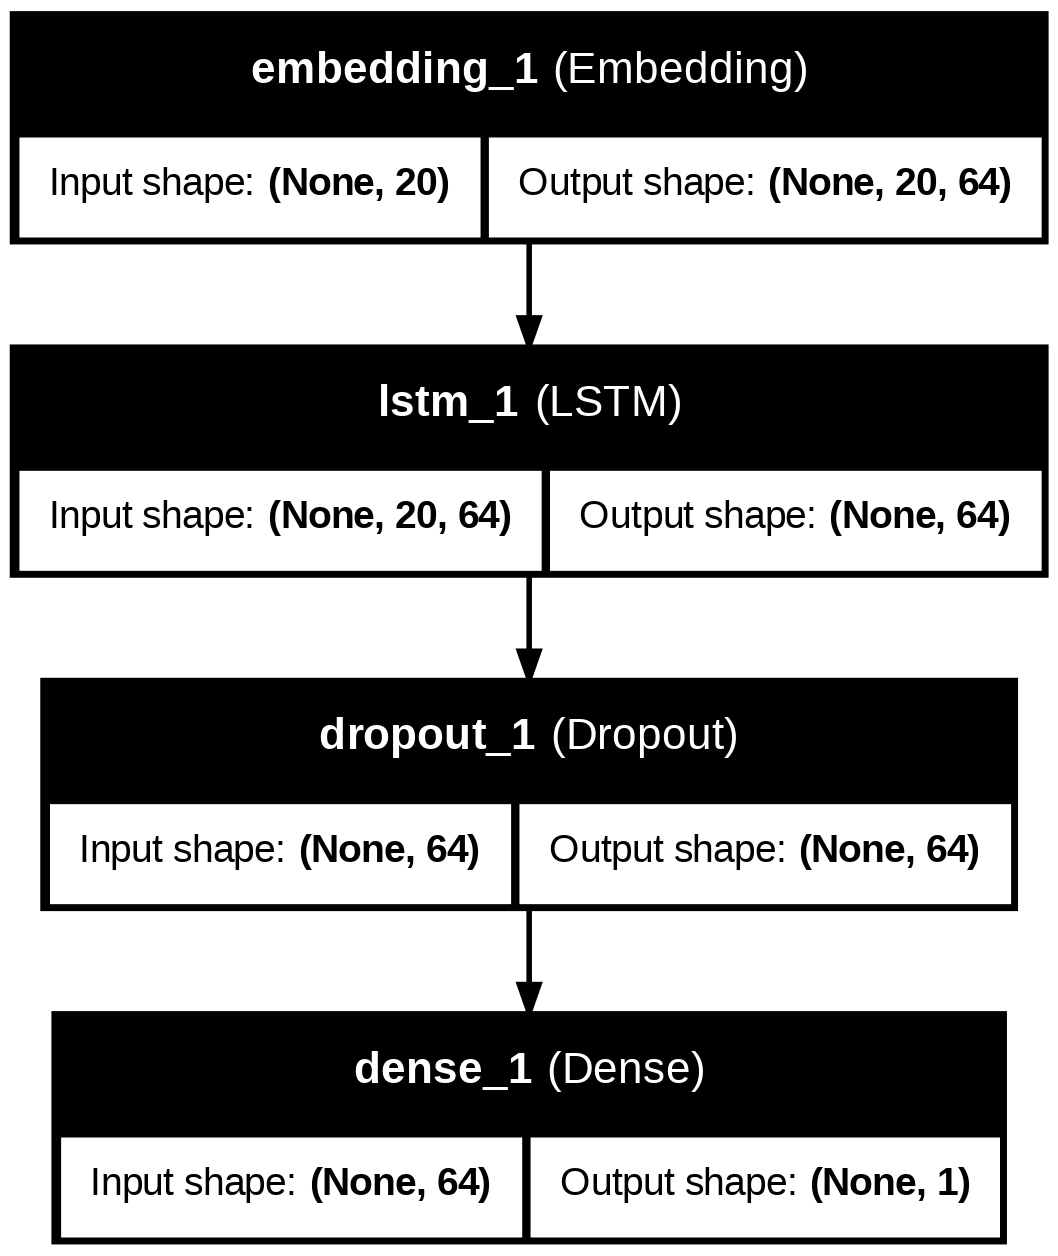

In [ ]:
# !pip install pydot
# !apt-get install -y graphviz  # for Google Colab or Linux

from tensorflow.keras.utils import plot_model

model.build(input_shape=(None, maxlen))
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


#S5. Training and Results

##Initial Train: Model Overfitting

In [ ]:
# history = model.fit(x_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.2)
#epochs=5 is too many in hindsight


# Epoch 1/5
# 898/898 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9039 - loss: 0.2293 - val_accuracy: 0.9659 - val_loss: 0.0959
# Epoch 2/5
# 898/898 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9848 - loss: 0.0473 - val_accuracy: 0.9687 - val_loss: 0.0893
# Epoch 3/5
# 898/898 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.9900 - loss: 0.0294 - val_accuracy: 0.9699 - val_loss: 0.0962
# Epoch 4/5
# 898/898 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9945 - loss: 0.0186 - val_accuracy: 0.9638 - val_loss: 0.1387
# Epoch 5/5
# 898/898 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9964 - loss: 0.0119 - val_accuracy: 0.9653 - val_loss: 0.1380


#the accuracy gradually rises over the epochs, while the loss is minimizes, this is optimizing it

#but after 2-3 epochs it starts to overfit as the training accuracy continues to grow whilst validation accuracy shrinks, meaning its memorizing


#training accuracy keeps increasing -> model is learning patterns

#training accuracy stops increasing -> model has peaked

#val loss increases -> model getting more confidence but wrong

#accuracy gap grows (train >> val) -> overfitting

##Retrain with Optimal Epochs

In [ ]:
#5 epochs of backprop made it overfit as val_loss began to grow while accuracy grew and val_accuracy dropped

#its prime was around 2-3, so remake with that in mind so it doesnt overtrain

history = model.fit(x_test_pad, y_test, epochs=3, batch_size=32, validation_split=0.2)

# Epoch 1/3
# 225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7953 - loss: 0.4017 - val_accuracy: 0.9621 - val_loss: 0.1139
# Epoch 2/3
# 225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9814 - loss: 0.0630 - val_accuracy: 0.9566 - val_loss: 0.1376
# Epoch 3/3
# 225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9915 - loss: 0.0323 - val_accuracy: 0.9594 - val_loss: 0.1215

Epoch 1/3
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7953 - loss: 0.4017 - val_accuracy: 0.9621 - val_loss: 0.1139
Epoch 2/3
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9814 - loss: 0.0630 - val_accuracy: 0.9566 - val_loss: 0.1376
Epoch 3/3
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9915 - loss: 0.0323 - val_accuracy: 0.9594 - val_loss: 0.1215


## Comparing Accuracies (99% Final)

In [ ]:
loss, accuracy = model.evaluate(x_test_pad, y_test)

print("test accuracy:", accuracy)

#281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9676 - loss: 0.1344
#test accuracy: 0.9667037725448608

#the binary crossentropy loss being close to zero (.13) means that the predicted is close to the actual,

#96% accurate on first run, this is high
#after redoing with lower epochs, sits around 99%

281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9970 - loss: 0.0147
test accuracy: 0.9898663759231567


#S6: Plotting Results

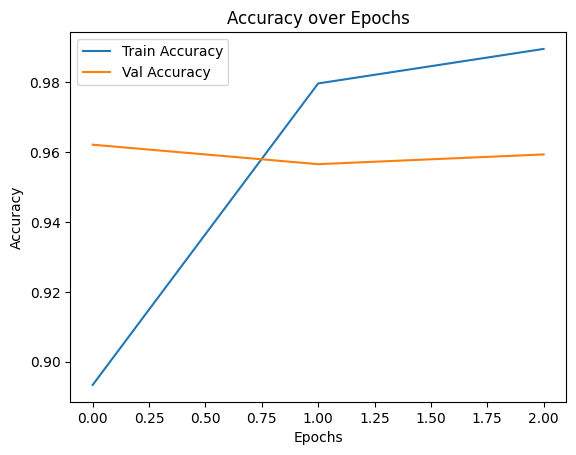

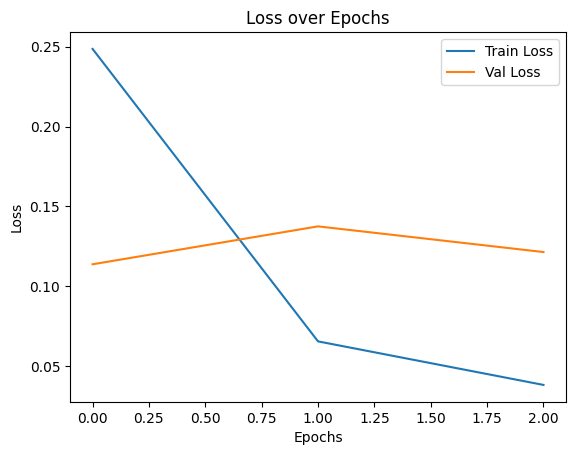

In [ ]:
import matplotlib.pyplot as plt

#accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

#loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.show()

#as epochs grow the training accuracy grows, and validation accuracy remains high

#as epochs grow the loss shrinks, validation loss stays low

#val accuracy/loss remaining constant measn that the model learned early as additional training
#mainly helped for the training set, and it means it generalized well from the start as
#the accuracy stayed high and flat, whilst loss stayed low too


#S7. Interactive Demonstration Game

In [ ]:
import random

print("Guess if the News Headline is Fake or Real News")
print("Type 'q' to Quit\n")

while True:

  # picks a random title

  #picks an id randomly in x_test for title
  #the title is x_test[idx], can index it like a list
  #true label is in the corresponding list for y, as x

  idx = random.randint(0, len(x_test) - 1)
  title = x_test[idx]
  true_label = y_test[idx]

  #same padding as before
  seq = tokenizer.texts_to_sequences([title])
  pad = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')


  #from the predictions, its either closer to 1 (real) or 0 (fake), so that determines what it thinks
  #closer to 1 = more confident its real
  #closer to 0 = more confident its fake

  pred_prob = model.predict(pad)[0][0]
  pred_label = 1 if pred_prob > 0.5 else 0

  print()

  print("Title:", title)

  answer = input("Real or Fake? You answer: ").strip().lower()
  print()

  if (answer=="real" and true_label==1) or (answer=="fake" and true_label==0):
    print("You are Correct")
  elif answer == 'q':
    print("Thanks for playing")
    break
  else:
    print("You are Incorrect")

  print()

  print("Actual:", "Real" if true_label == 1 else "Fake")
  print("Model Predicted:", "Real" if pred_label == 1 else "Fake")
  print("Model's Confidence that this article is factually accurate", int(round(pred_prob, 2))*100, "%")

  for i in range(2):
    print()


Guess if the News Headline is Fake or Real News
Type 'q' to Quit

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Title: U.N. official's visit to North Korea sparks hope of mediation role
Real or Fake? You answer: real

You are Correct

Actual: Real
Model Predicted: Real
Model's Confidence that this article is factually accurate 100 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Title: #CHARLOTTESVILLE’S Vice-Mayor Disrespects Trump…Here’s Why He Refuses to Call Him President Trump [Video]
Real or Fake? You answer: real

You are Incorrect

Actual: Fake
Model Predicted: Fake
Model's Confidence that this article is factually accurate 0 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Title: Justice Department appeals judge's immigration order


KeyboardInterrupt: Interrupted by user